# APS - new snow

## Imports

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
from __future__ import print_function
import pylab as plt
import datetime
import numpy as np
plt.rcParams['figure.figsize'] = (14, 6)

## Parameters, categories and scores

### Main control factors

In [2]:
# New snow amount last 24 h 0-60 cm [10 cm intervals]
new_snow_24h_cat = np.array([0, 20, 40, 60, 80, 100, 120])
new_snow_24h_score = np.array([0.5, 8.0, 15.0, 19., 21.0, 27.0, 33.3])

# Wind speed 0-100 km/h [0,10,20,30,40,50,60,80,100]
wind_speed_cat = np.array([-1.5, 0, 2.5, 5, 7.5, 10, 15, 20, 25, 30, 40]) # m/s
wind_speed_score = np.array([-1.0, 0.8, 2.0, 2.9, 3.2, 3.0, 1.1, 0.6, 0.4, 0.2, 0.0])

### Weighting
Weights are added if they are independent of the value of the core factor or multiplied if they are related to the core factor.

In [3]:
# New snow amount last 24-72h 0-100 cm [0,10,20,30,40,50,60,80,100]
new_snow_24_72h_cat = np.array([0, 10, 20, 30, 40, 50, 60, 80, 100])
new_snow_24_72h_weight = np.array([0.8, 0.83, 0.86, 0.89, 0.92, 0.95, 0.98, 0.99, 1.0]) # a weight for new_snow_24h

# Evolution of temperature
evolution_temperature_cat = ["constant very cold",
                             "constant cold",
                             "constant warm",
                             "rise towards 0 deg after snowfall",
                             "substantial cooling after snowfall"]

# Bonding to existing snowpack 
bonding_existing_snowpack_cat = ["favorable", "moderate", "poor"]

# Type of new snow 
type_new_snow_cat = ["loose-powder", "soft", "packed", "packed and moist"]

The *new_snow_24_72h_weight* are used to weight the *new_snow_24h_scores* prior to multiplying it with *wind_speed_score*.

In order to achive a smooth fit within the range of interest I added some control points just right outside the normal range for the higher order polynomials.

The temperature evolution during a snowfall can be fitted to a curve which can then be compared to predefined curves/scenarios. The scenario with the best correlation is chosen to define the category.
Temperature or change in snow depth will be used if the precipitation event is rain or snow when applied to data from a weather station. The AROME model generally supplies that separation.  

The *type_new_snow_cat* can be infered from *evolution_temperature* and *wind_speed*.

In the first place the categories can be set manually.

## Score functions

### New snow 24 h

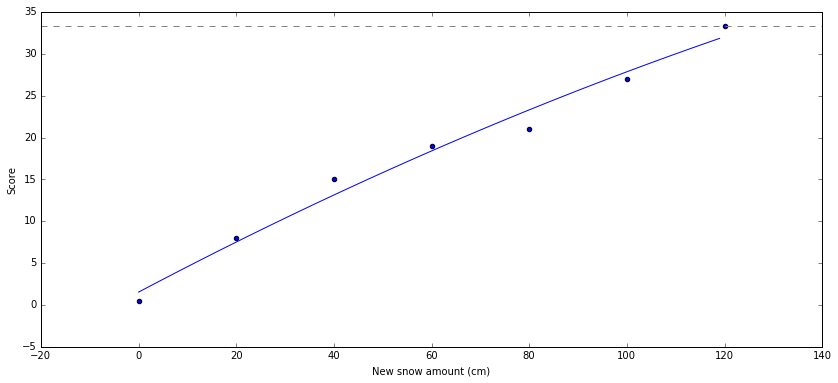

In [4]:
new_snow_24h_fit = np.polyfit(new_snow_24h_cat, new_snow_24h_score, 2)
score_new_snow_24h = np.poly1d(new_snow_24h_fit)

x = np.arange(0, 120.0)
res = score_new_snow_24h(x)

plt.scatter(new_snow_24h_cat, new_snow_24h_score)
plt.plot(x, res)
plt.xlabel('New snow amount (cm)')
plt.ylabel('Score')
plt.axhline(33.3, color='grey', ls='--')

### New snow 24-72 h

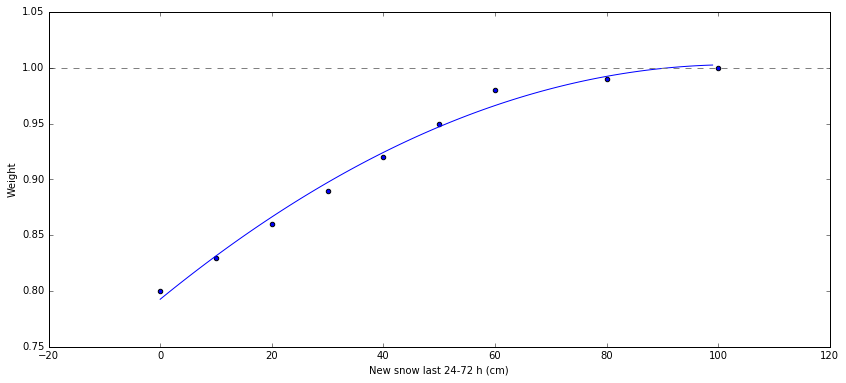

In [5]:
new_snow_24_72h_fit = np.polyfit(new_snow_24_72h_cat, new_snow_24_72h_weight, 2)
score_new_snow_24_72h = np.poly1d(new_snow_24_72h_fit)

x = np.arange(0, 100.0)
res = score_new_snow_24_72h(x)

plt.scatter(new_snow_24_72h_cat, new_snow_24_72h_weight)
plt.plot(x, res)
plt.xlabel('New snow last 24-72 h (cm)')
plt.ylabel('Weight')
plt.axhline(1.0, color='grey', ls='--')

### Wind speed

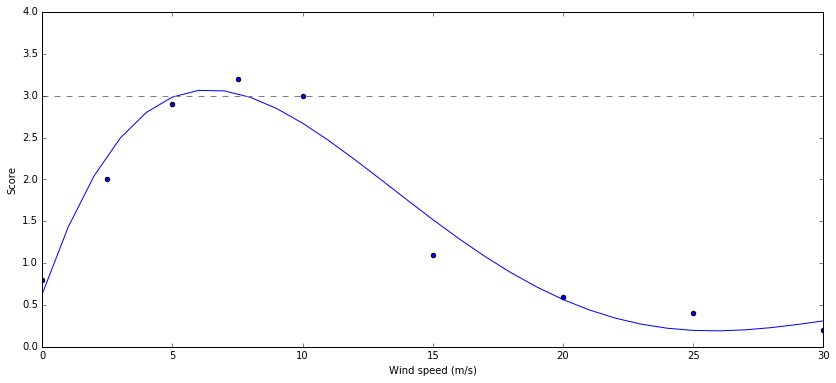

In [51]:
wind_speed_fit = np.polyfit(wind_speed_cat, wind_speed_score, 5)
score_wind_speed = np.poly1d(wind_speed_fit)

x = np.arange(-5, 45.0)
res = score_wind_speed(x)

plt.scatter(wind_speed_cat, wind_speed_score)
plt.plot(x, res)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Score')
plt.xlim(0, 30)
plt.ylim(0, 4)
#plt.axvspan(0.0, 36.0, facecolor='grey', alpha=0.5) # model validity range
plt.axhline(3.0, color='grey', ls='--')

## New snow vs. wind speed

Min 0.23767784555323504; Max 92.99693990293554


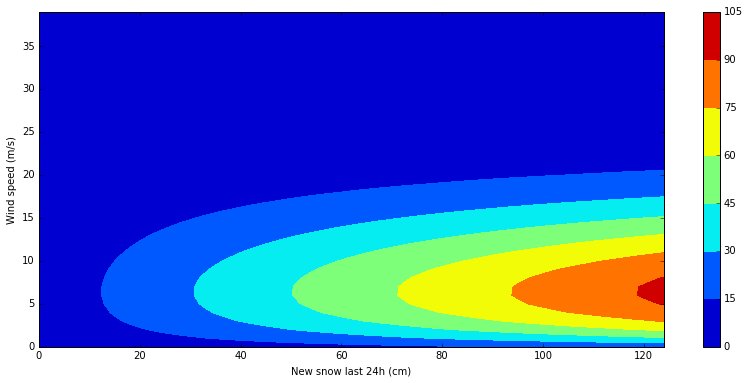

In [7]:
new_snow = np.matrix(np.arange(0, 125.0))
sns = score_new_snow_24h(new_snow)

# weighted by new snow amount of the previous two days
new_snow_72 = 40
ns_weight = score_new_snow_24_72h(new_snow_72)

sns *= ns_weight

wind_speed = np.matrix(np.arange(0, 40.0))
swp = score_wind_speed(wind_speed)

M = np.multiply(sns, swp.T)
#print(M)
plt.contourf(M)#np.flipud(M.T))
print("Min {0}; Max {1}".format(np.amin(M), np.amax(M)))
plt.colorbar()
plt.xlabel("New snow last 24h (cm)")
plt.ylabel("Wind speed (m/s)")

# ToDo

- calculate new_snow_score for some weeks
- compare to chosen AP in regional forecast
- maybe extent to a larger grid


...continue with hemsedal_jan2016.py in Test

## Working with real data
Load data from filefjell.db containing two weeks of met-data from the station.
The database was generated by the notebook "xgeo_chartserver".

In [33]:
import sqlite3
import pandas as pd

In [34]:
db_name = 'filefjell.db'
conn = sqlite3.connect(db_name)
cur = conn.cursor()

In [35]:
sql = "SELECT * from FILEFJELL"
df = pd.read_sql(sql, conn, index_col='index', parse_dates=['index']) #
conn.close()
df.head()

,"FILEFJELL - KYRKJESTØLANE (54710), Nedbør (mm)","FILEFJELL - KYRKJESTØLANE (54710), Lufttemperatur (°C)","FILEFJELL - KYRKJESTØLANE (54710), Vindhastighet 10m (m/s)","FILEFJELL - KYRKJESTØLANE (54710), Snødybde (cm)"
index,,,,
2016-01-27 00:00:00,1.1,-2.1,4.7,48.0
2016-01-27 01:00:00,0.1,-1.9,3.9,49.0
2016-01-27 02:00:00,0.0,3.3,5.2,49.0
2016-01-27 03:00:00,0.0,4.1,7.3,49.0
2016-01-27 04:00:00,0.0,3.5,8.8,48.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010B0FC50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001043EB00>], dtype=object)

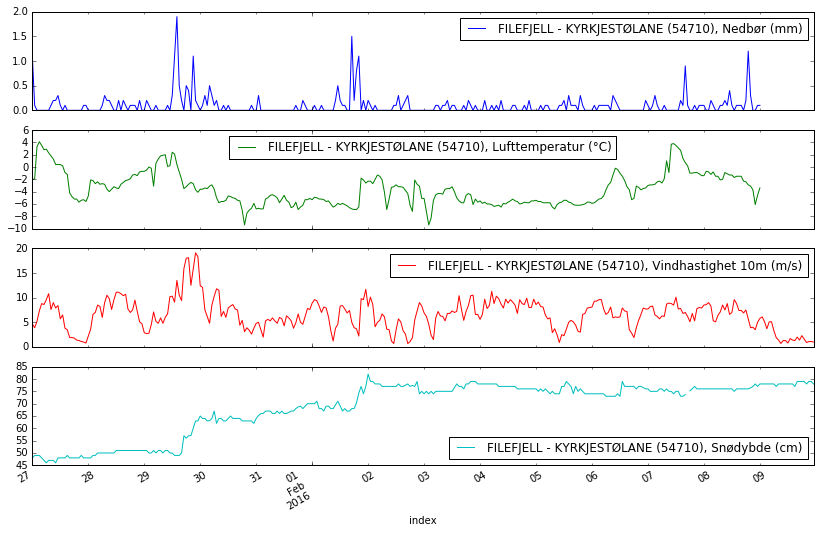

In [36]:
df.plot(subplots='True', figsize=(14, 9))

Derive required input for new snow problem:
- new snow amount last 0-24 h
- new snow amount last 24-72 h
- temperature gradient last 6 h (relate temperature to settling rate of previous snow falls)

In [12]:
#df['24h_precip'] = df['FILEFJELL - KYRKJESTØLANE (54710), Nedbør (mm)'].rolling(window=24).sum()
#df['72h_precip'] = df['FILEFJELL - KYRKJESTØLANE (54710), Nedbør (mm)'].rolling(window=72).sum()

In [13]:
# add function the treats the occurence of rain -> no new_snow_score, drastically reduce wind_score
df['snow_score'] = score_new_snow_24h(df['24h_precip']*10.0)
df['wind_score'] = score_wind_speed(df['FILEFJELL - KYRKJESTØLANE (54710), Vindhastighet 10m (m/s)'])
df['72snow_score'] = score_new_snow_24_72h(df['72h_precip']*10.0)
df['new_snow_score'] = (df['snow_score'] * df['wind_score']) + df['72snow_score']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000097DA7F0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000B26F6A0>], dtype=object)

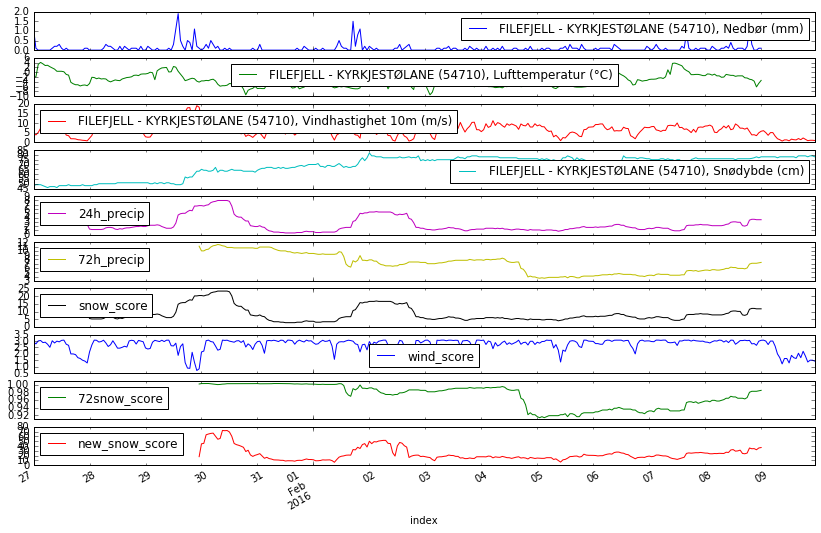

In [14]:
df.plot(subplots='True', figsize=(14, 9))

Select certain days using .loc. Works before or after the ['column_name']. See http://pandas.pydata.org/pandas-docs/stable/indexing.html#selection-by-label

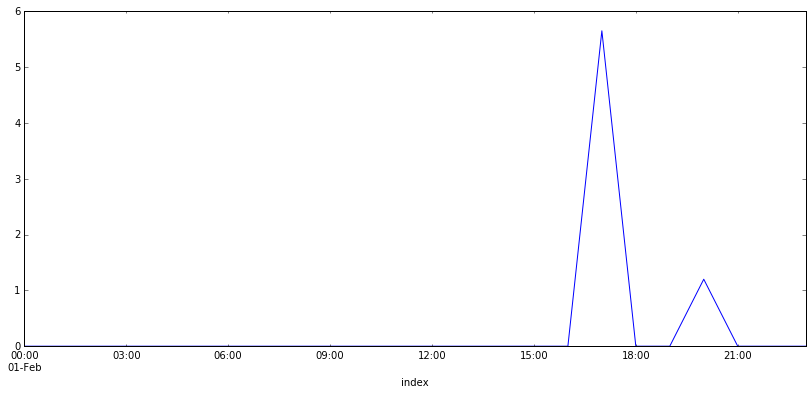

In [48]:
df.loc['20160201']['new_snow_score'].plot()

Or meteorological day

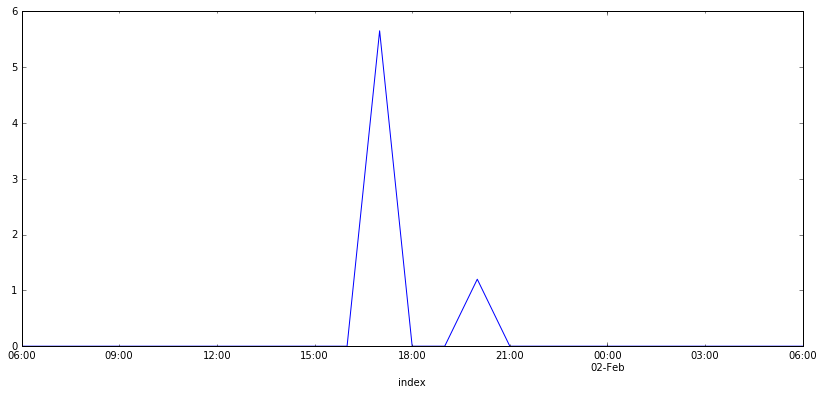

In [49]:
df['new_snow_score'].loc['20160201T06:00:00':'20160202T06:00:00'].plot()

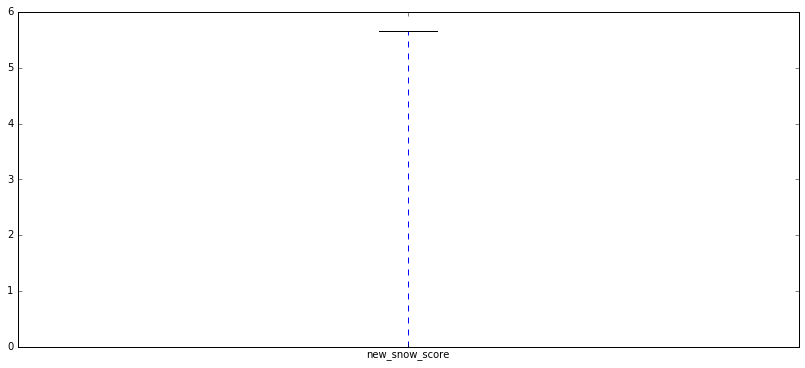

In [50]:
sday = df.loc['20160201']
sday['new_snow_score'].describe()
sday['new_snow_score'].plot.box()

## Hourly score- and decay-functions

The score function for the new snow problem is of type $$ s = a \cdot \log_b{x} $$
The decay function for the new snow problem is of type $$ d = a \cdot b^x $$

In [37]:
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit

def score_func(x, a, b, c):
    return a * (1. / np.log(b)) * np.log(x) + c

def decay_func(x, a, b):
    return a * b ** x

### Score function

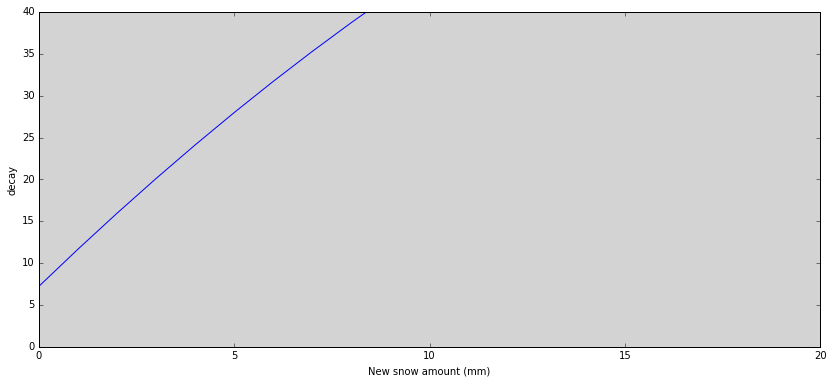

In [43]:
# Hourly new snow amount in mm water equivalent
control_points = np.array([
        [0.05, 0.],
        [0.2, 5.],
        [0.5, 10.],
        [1., 20.],
        [4., 30.],
        [10., 40.],
        [20., 70.]
    ])
new_snow_1h_cat = control_points[:, 0] #np.array([-2, 0.1, 0.2, 0.5, 1.0, 4.0, 10.0])
new_snow_1h_score = control_points[:, 1] #np.array([100.0, 50.0, 15.0, 2.0, 0.0, -10.0, -50])


#params = curve_fit(score_func, new_snow_1h_cat, new_snow_1h_score)

#[a, b, c] = params[0]
#print(a, b, c)

new_snow_1h_fit = np.polyfit(new_snow_1h_cat, new_snow_1h_score, 2)
score_new_snow_1h = np.poly1d(new_snow_1h_fit)

x = np.arange(0, 40.0)
res = score_new_snow_1h(x)
#res1 = score_func(x, a, b, c)

plt.scatter(new_snow_1h_cat, new_snow_1h_score)
plt.plot(x, res)
#plt.plot(x, res1)
plt.xlabel('New snow amount (mm)')
plt.ylabel('decay')
plt.xlim(0, 20); plt.ylim(0, 40)
plt.gca().add_patch(Rectangle((0, 0), 40, 100, edgecolor="lightgrey", facecolor="lightgrey"))

### Decay function

24.0304613284 0.487520272089


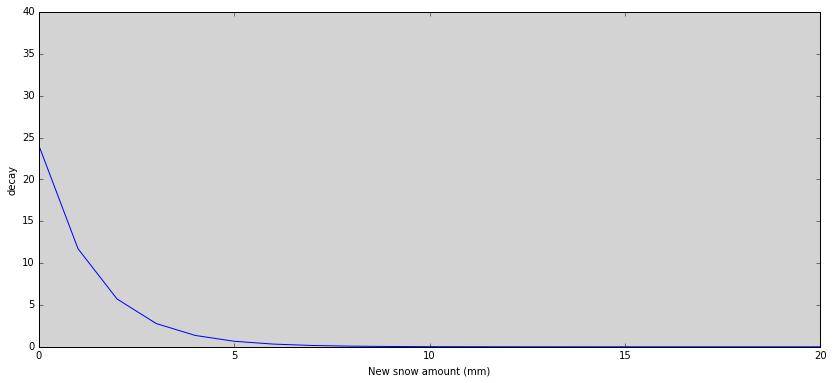

In [44]:
# Hourly new snow amount in mm water equivalent
control_points = np.array([
        [-2., 100.],
        [0.1, 50],
        [0.2, 15.],
        [0.5, 2.],
        [1., 0.]#,
        #[4., -10.],
        #[10., -50.]
    ])
new_snow_1h_decay_cat = control_points[:, 0] #np.array([-2, 0.1, 0.2, 0.5, 1.0, 4.0, 10.0])
new_snow_1h_decay_score = control_points[:, 1] #np.array([100.0, 50.0, 15.0, 2.0, 0.0, -10.0, -50])


params = curve_fit(decay_func, new_snow_1h_decay_cat, new_snow_1h_decay_score)

[a, b] = params[0]
print(a, b)

x = np.arange(0, 40.0)
res = decay_func(x, a, b)

plt.scatter(new_snow_1h_decay_cat, new_snow_1h_decay_score)
plt.plot(x, res)

plt.xlabel('New snow amount (mm)')
plt.ylabel('decay')
plt.xlim(0, 20); plt.ylim(0, 40)
plt.gca().add_patch(Rectangle((0, 0), 40, 100, edgecolor="lightgrey", facecolor="lightgrey"))

### Summing up the scores and decays

In [58]:
def score_sum(new_snow_score, new_snow_decay, wind_speed_score):
    _sum = np.zeros_like(new_snow_score)
    _sum[0] = np.clip((new_snow_score[0] * wind_speed_score[0] - new_snow_decay[0]), 0, 100)
    for i in np.arange(1, len(new_snow_score)):
        _sum[i] = np.clip(_sum[i-1] + (new_snow_score[i] * wind_speed_score[i] - new_snow_decay[i]), 0, 100)
                    
    return _sum

In [59]:
df['wind_score'] = score_wind_speed(df['FILEFJELL - KYRKJESTØLANE (54710), Vindhastighet 10m (m/s)'])

df['snow_score'] = score_new_snow_1h(df['FILEFJELL - KYRKJESTØLANE (54710), Nedbør (mm)'])
df['snow_decay'] = decay_func(df['FILEFJELL - KYRKJESTØLANE (54710), Nedbør (mm)'], a, b)
df['new_snow_score'] = score_sum(df['snow_score'], df['snow_decay'], df['wind_score'])

#TODO: add a wind_speed_decay function; should we need to regard wind_direction?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000014076320>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001424EFD0>], dtype=object)

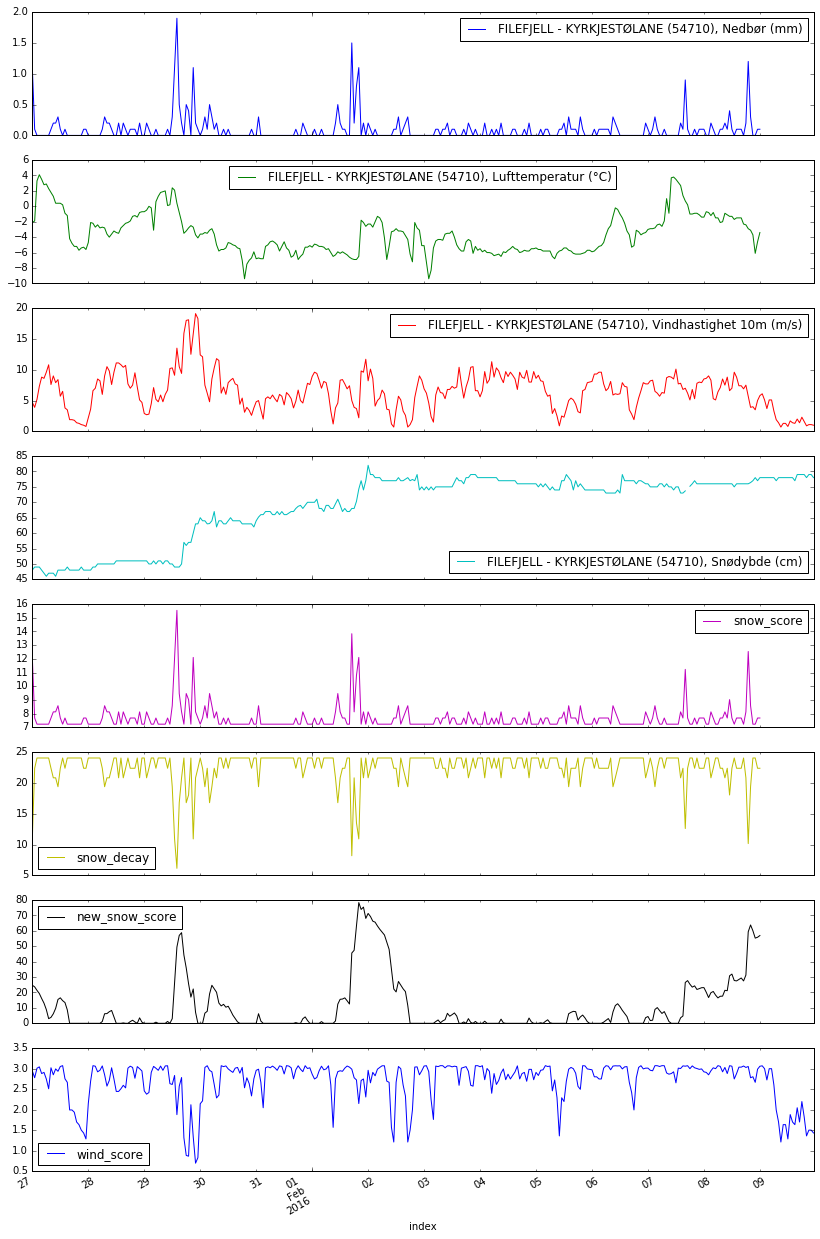

In [60]:
df.plot(subplots='True', figsize=(14, 23))

# Random scripting testing

In [7]:
new_snow_cat = ["0-5", "5-10", "10-15", "15-20"]
new_snow_thres = {(0, 5): 0.2, (5, 10): 0.5, (10, 15): 1, (15, 20): 3}

wind_cat = ["0-3", "4-7", "8-10", "10-15", "16-30"]
wind_thres = {(0, 3): 0.2, (3, 7): 1, (7, 10): 2, (10, 15): 0.2, (15, 30): 0.01}


new_snow_region = np.array([[0, 4, 6, 18],
                             [0, 4, 6, 18],
                             [0, 4, 6, 18]])

wind_region = np.array([[0, 4, 12, 18],
                         [4, 0, 18, 6],
                         [18, 12, 6, 0]])

In [74]:
def get_score(a, score_dict):
    for key, value in score_dict.items():
        if key[0] <= a < key[1]:
    #    if a < key:
            return value
            break
    return None

the dict is not sorted and the comparison *less than* is random...

In [75]:
new_snow_region_score = [get_score(a, new_snow_thres) for a in new_snow_region.flatten()]
new_snow_region_score = np.array(new_snow_region_score).reshape(new_snow_region.shape)
print(new_snow_region_score)

[[ 0.2  0.2  0.5  3. ]
 [ 0.2  0.2  0.5  3. ]
 [ 0.2  0.2  0.5  3. ]]


In [76]:
wind_region_score = [get_score(a, wind_thres) for a in wind_region.flatten()]
wind_region_score = np.array(wind_region_score).reshape(wind_region.shape)
print(wind_region_score)

[[ 0.2   1.    0.2   0.01]
 [ 1.    0.2   0.01  1.  ]
 [ 0.01  0.2   1.    0.2 ]]


In [77]:
print(wind_region_score * new_snow_region_score)

[[  4.00000000e-02   2.00000000e-01   1.00000000e-01   3.00000000e-02]
 [  2.00000000e-01   4.00000000e-02   5.00000000e-03   3.00000000e+00]
 [  2.00000000e-03   4.00000000e-02   5.00000000e-01   6.00000000e-01]]


[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]]
[[ 10.]
 [ 11.]
 [ 12.]
 [ 13.]
 [ 14.]
 [ 15.]
 [ 16.]
 [ 17.]
 [ 18.]
 [ 19.]
 [ 20.]]
[[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.]
 [   0.   11.   22.   33.   44.   55.   66.   77.   88.   99.  110.]
 [   0.   12.   24.   36.   48.   60.   72.   84.   96.  108.  120.]
 [   0.   13.   26.   39.   52.   65.   78.   91.  104.  117.  130.]
 [   0.   14.   28.   42.   56.   70.   84.   98.  112.  126.  140.]
 [   0.   15.   30.   45.   60.   75.   90.  105.  120.  135.  150.]
 [   0.   16.   32.   48.   64.   80.   96.  112.  128.  144.  160.]
 [   0.   17.   34.   51.   68.   85.  102.  119.  136.  153.  170.]
 [   0.   18.   36.   54.   72.   90.  108.  126.  144.  162.  180.]
 [   0.   19.   38.   57.   76.   95.  114.  133.  152.  171.  190.]
 [   0.   20.   40.   60.   80.  100.  120.  140.  160.  180.  200.]]
Min 0.0; Max 200.0


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


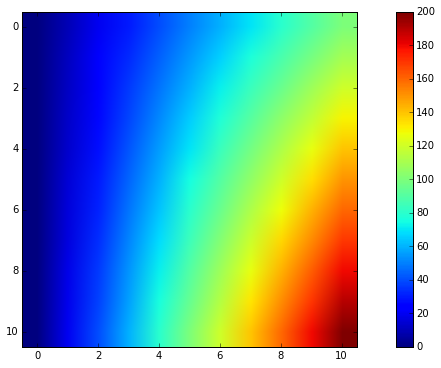

In [86]:
X = np.matrix(np.arange(0, 11.0))
Y = np.matrix(np.arange(10.0, 21.0))

Z = np.multiply(X, Y.T)
print(X)
print(Y.T)
print(Z)
plt.imshow(Z)
print("Min {0}; Max {1}".format(np.amin(Z), np.amax(Z)))
plt.colorbar()

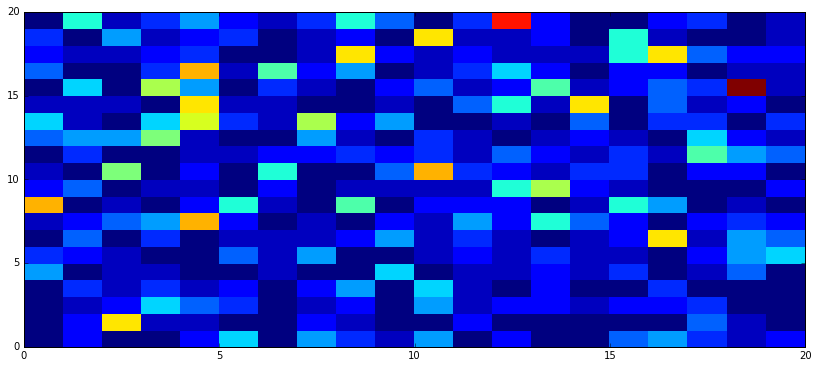

In [58]:
arr = np.random.geometric(0.3, (20, 20))
plt.pcolor(arr)

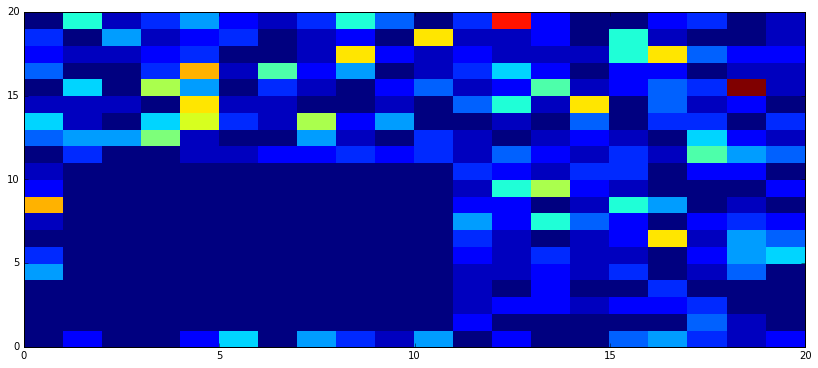

In [72]:
window = arr[1:11,1:11]
arr[1:11,1:11] = 1
plt.pcolor(arr)

In [71]:
print(np.median(window))
print(window.flatten())
print(np.bincount(window.flatten()))
print(np.sort(window, axis=None))

2.0
[ 1  1  1  1  2  2  2  3  3 13  1  1  2  2  3  3  4  5  6  7  1  1  2  2  3
  3  4  4  6  7  1  1  1  1  1  1  2  2  2  7  1  1  1  1  2  2  2  3  5  6
  1  1  2  2  2  2  3  4  5  6  1  1  2  2  3  3  3  5  6 14  1  1  1  1  2
  2  3  3  8  9  1  1  1  2  2  2  2  2  3  5  1  1  1  1  1  3  5  8 10 14]
[ 0 34 26 15  4  6  5  3  2  1  1  0  0  1  2]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  5  5  5  5  5  5  6  6  6  6  6  7  7  7  8  8  9 10 13 14 14]
